In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [9]:
import matplotlib
np.__version__, pd.__version__, sns.__version__, matplotlib.__version__

('1.25.2', '1.5.3', '0.12.2', '3.7.2')

**1. Load Data**

In [10]:
df = pd.read_csv('dataset/cars.csv')

In [11]:
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


In [12]:
df.shape

(8128, 13)

In [13]:
df.describe()

,year,selling_price,km_driven,seats
count,8128.000000,8.128000e+03,8.128000e+03,7907.000000
mean,2013.804011,6.382718e+05,6.981951e+04,5.416719
std,4.044249,8.062534e+05,5.655055e+04,0.959588
min,1983.000000,2.999900e+04,1.000000e+00,2.000000
25%,2011.000000,2.549990e+05,3.500000e+04,5.000000
50%,2015.000000,4.500000e+05,6.000000e+04,5.000000
75%,2017.000000,6.750000e+05,9.800000e+04,5.000000
max,2020.000000,1.000000e+07,2.360457e+06,14.000000


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           8128 non-null   object 
 1   year           8128 non-null   int64  
 2   selling_price  8128 non-null   int64  
 3   km_driven      8128 non-null   int64  
 4   fuel           8128 non-null   object 
 5   seller_type    8128 non-null   object 
 6   transmission   8128 non-null   object 
 7   owner          8128 non-null   object 
 8   mileage        7907 non-null   object 
 9   engine         7907 non-null   object 
 10  max_power      7913 non-null   object 
 11  torque         7906 non-null   object 
 12  seats          7907 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 825.6+ KB


In [15]:
df.columns

Index(['name', 'year', 'selling_price', 'km_driven', 'fuel', 'seller_type',
       'transmission', 'owner', 'mileage', 'engine', 'max_power', 'torque',
       'seats'],
      dtype='object')

**2 Explatory Data Analysis**

2.1 Univariate analysis

Countplot

<Axes: xlabel='seller_type', ylabel='count'>

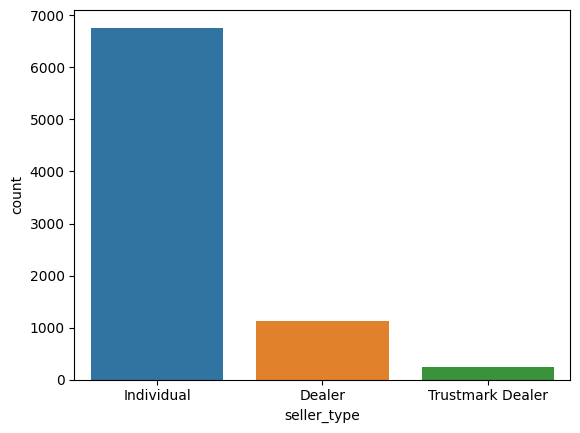

In [16]:
# Let's see how many individual and dealer sellers are there
sns.countplot(data = df, x = 'seller_type')

Distribution plot

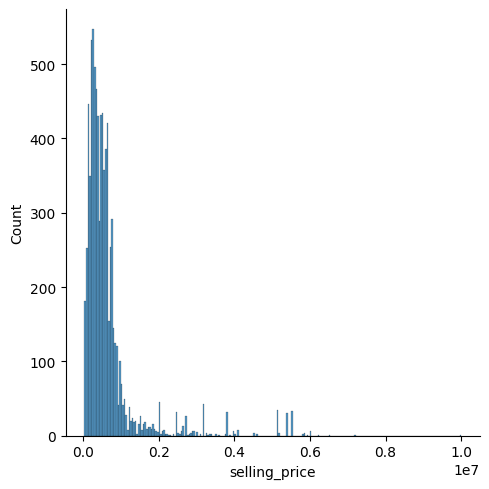

In [17]:
# Distribution plot for selling prices
sns.displot(data = df, x = 'selling_price')

2.2 Multivariate Analysis

Multiple variable exploratory analysis

Boxplot

Text(0.5, 0, 'Seller Type')

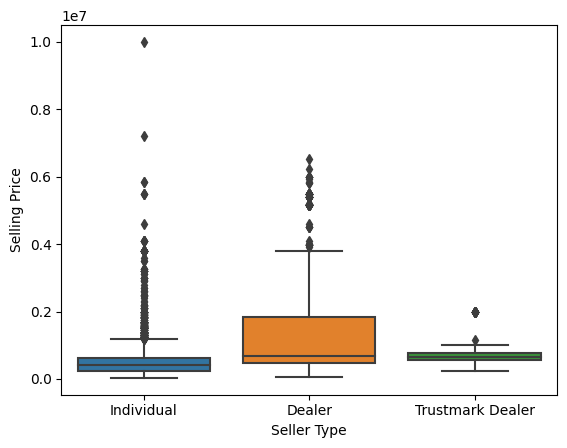

In [18]:
# Trying the box plot on 'seller_type'
sns.boxplot(x = df["seller_type"], y = df["selling_price"]);
plt.ylabel("Selling Price")
plt.xlabel("Seller Type")

Scatterplot

<Axes: xlabel='km_driven', ylabel='selling_price'>

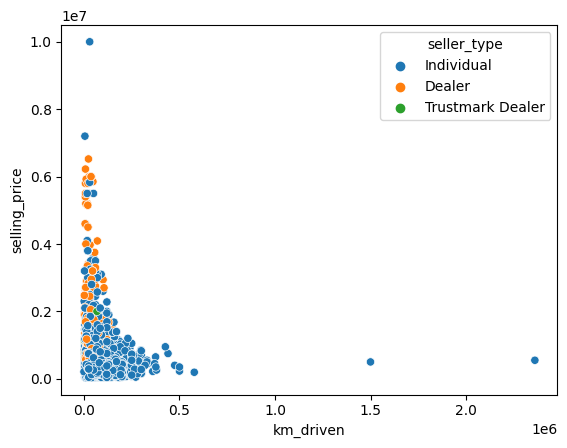

In [19]:
sns.scatterplot(x = df['km_driven'], y = df['selling_price'], hue =df['seller_type'])

Corelation Matrix

<Axes: >

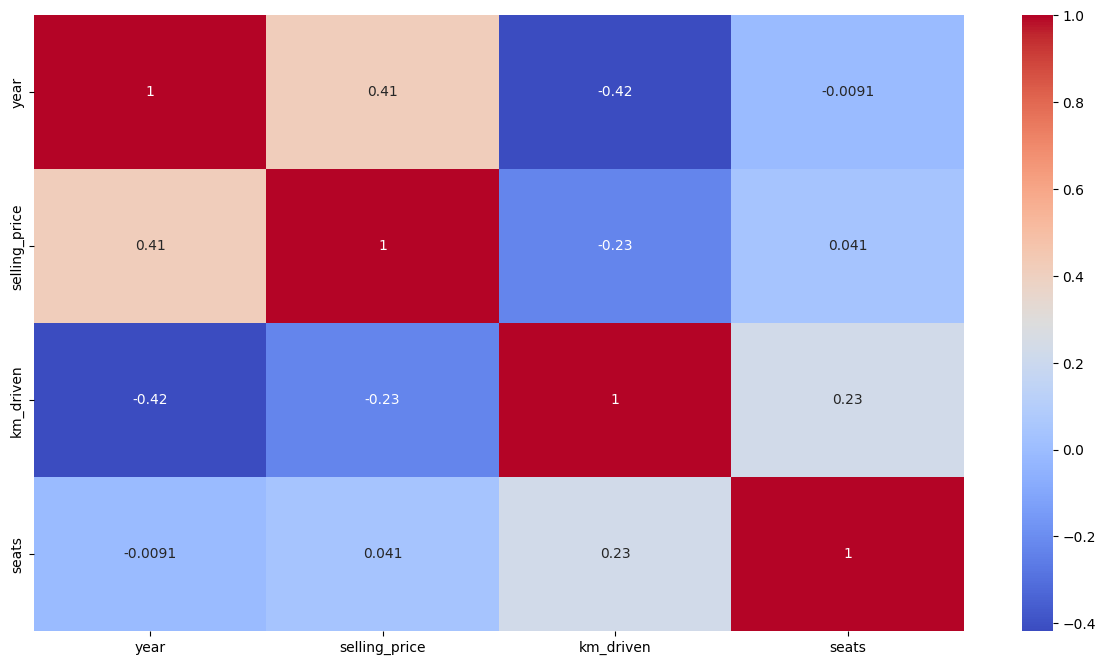

In [20]:
plt.figure(figsize = (15, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")

Label Encoding

In [21]:
from sklearn.preprocessing import LabelEncoder

# Encoding the feature "seller_type"

le = LabelEncoder()
df["seller_type"] = le.fit_transform(df["seller_type"])

df["seller_type"].unique()

array([1, 0, 2])

In [22]:
le.classes_

array(['Dealer', 'Individual', 'Trustmark Dealer'], dtype=object)

In [23]:
le.transform(["Dealer", "Individual", "Trustmark Dealer"])

array([0, 1, 2])

<Axes: >

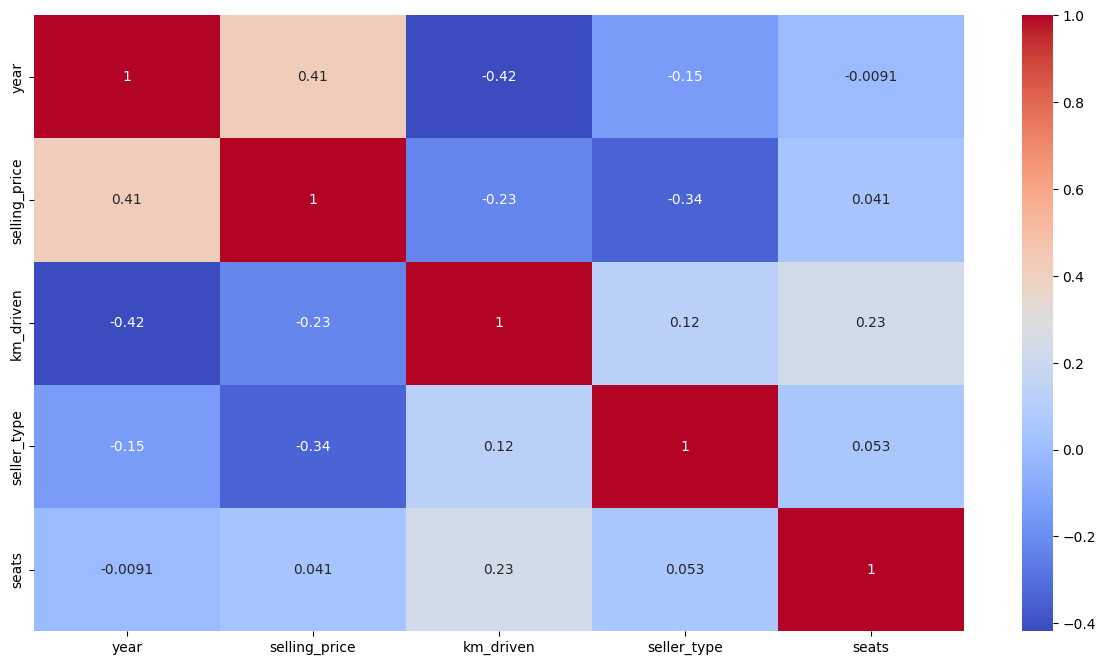

In [24]:
plt.figure(figsize = (15, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")

In [25]:
# Encoding the feature fuel type

df['fuel'].unique()

array(['Diesel', 'Petrol', 'LPG', 'CNG'], dtype=object)

In [26]:
# All the rows with fuel values CNG and LPG will be removed

df = df[~df['fuel'].isin(['CNG', 'LPG'])]
df['fuel'].unique()

array(['Diesel', 'Petrol'], dtype=object)

In [27]:
# Now the remaining labels for feature fuel will be encoded

df['fuel'] = le.fit_transform(df['fuel'])
df['fuel'].unique()

array([0, 1])

In [28]:
le.classes_

array(['Diesel', 'Petrol'], dtype=object)

In [29]:
le.transform(['Diesel', 'Petrol'])

array([0, 1])

<Axes: >

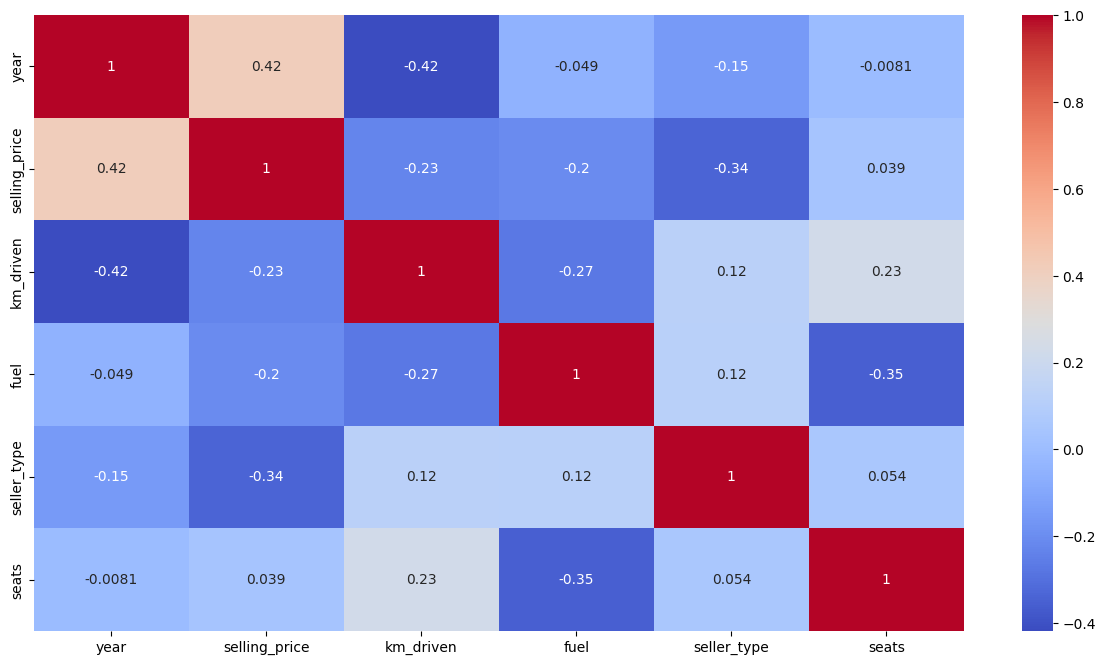

In [30]:
plt.figure(figsize = (15,8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")

In [31]:
# Encoding the feature "transmission"

df['transmission'] = le.fit_transform(df['transmission'])
df['transmission'].unique()

array([1, 0])

In [32]:
le.classes_

array(['Automatic', 'Manual'], dtype=object)

In [33]:
le.transform(['Automatic', 'Manual'])

array([0, 1])

<Axes: >

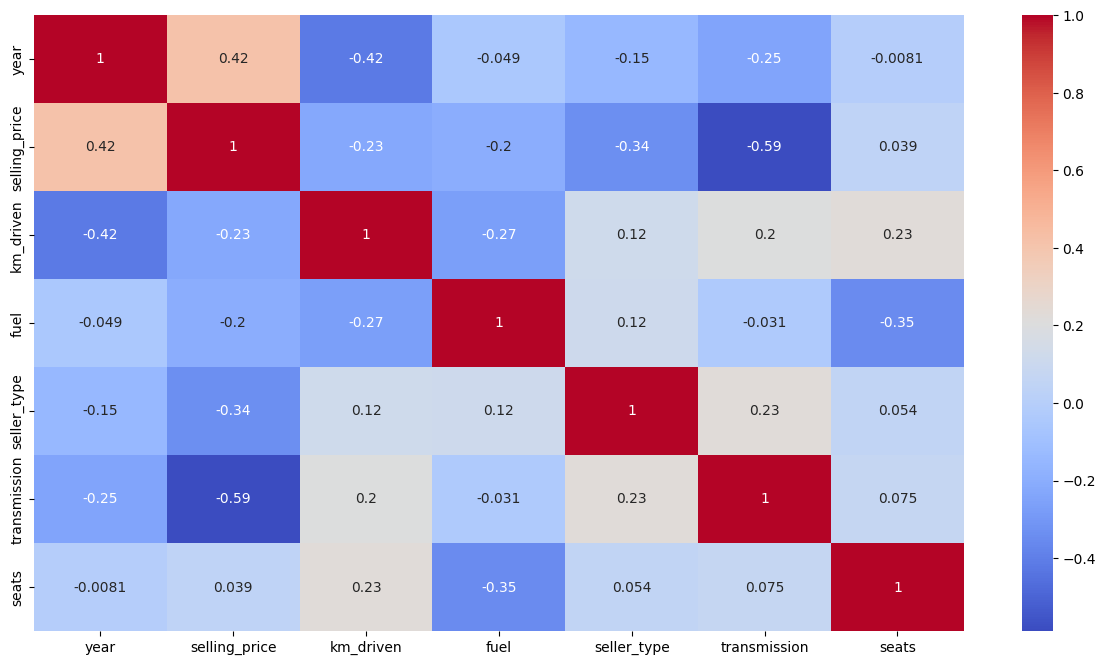

In [34]:
plt.figure(figsize = (15,8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")

In [35]:
#Encoding the feature owner

df['owner'].unique()

array(['First Owner', 'Second Owner', 'Third Owner',
       'Fourth & Above Owner', 'Test Drive Car'], dtype=object)

In [36]:
mapping = {
    'First Owner': 1,
    'Second Owner': 2,
    'Third Owner': 3,
    'Fourth & Above Owner': 4,
    'Test Drive Car': 5
}

df['owner'] = df['owner'].map(lambda x : mapping[x])

In [37]:
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,0,1,1,1,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,0,1,1,2,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,1,1,1,3,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,0,1,1,1,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,1,1,1,1,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


<Axes: >

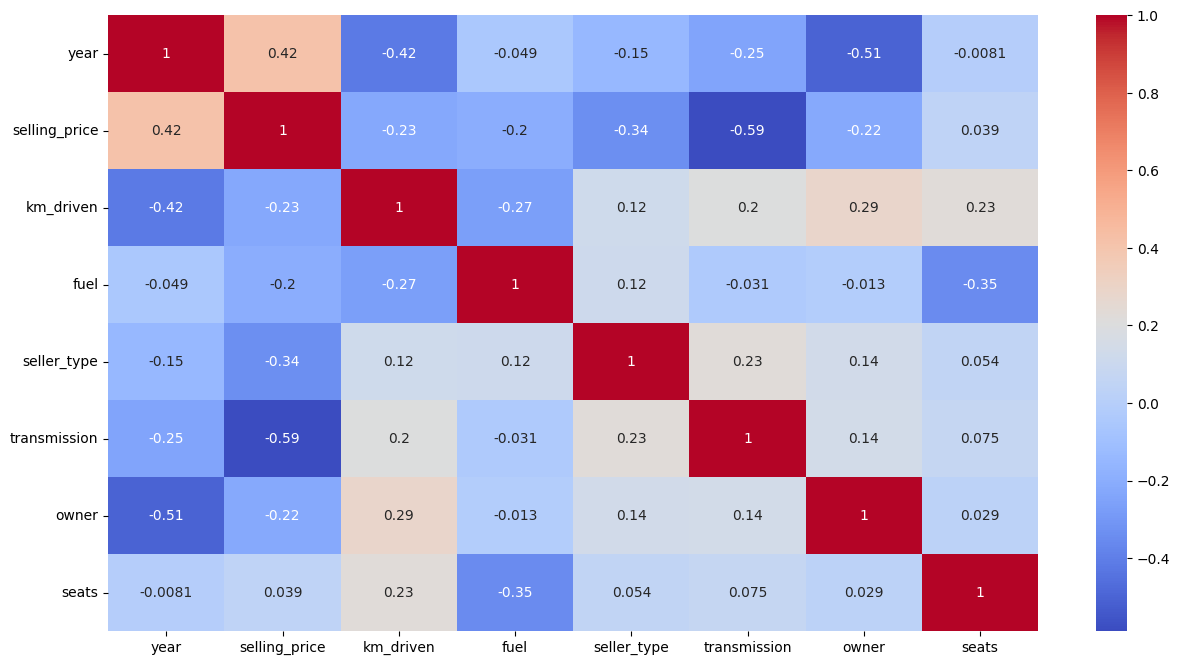

In [38]:
plt.figure(figsize = (15,8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")

In [39]:
# Removing the kmpl string from mileage values
# First we need to remove rows with null mileage values

df = df[df['mileage'].apply(lambda x: isinstance(x, str))]
df['mileage'] = df['mileage'].map(lambda x : float(x.split(' ')[0]))
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,0,1,1,1,23.40,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,0,1,1,2,21.14,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,1,1,1,3,17.70,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,0,1,1,1,23.00,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,1,1,1,1,16.10,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


In [40]:
# Same for engine, we remove CC from the values

df = df[df['engine'].apply(lambda x: isinstance(x, str))]
df['engine'] = df['engine'].map(lambda x : float(x.split(' ')[0]))
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,0,1,1,1,23.40,1248.0,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,0,1,1,2,21.14,1498.0,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,1,1,1,3,17.70,1497.0,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,0,1,1,1,23.00,1396.0,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,1,1,1,1,16.10,1298.0,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


In [41]:
# Same for max power, we remove CC from the values

df = df[df['max_power'].apply(lambda x: isinstance(x, str))]
df['max_power'] = df['max_power'].map(lambda x : float(x.split(' ')[0]))
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,0,1,1,1,23.40,1248.0,74.00,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,0,1,1,2,21.14,1498.0,103.52,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,1,1,1,3,17.70,1497.0,78.00,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,0,1,1,1,23.00,1396.0,90.00,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,1,1,1,1,16.10,1298.0,88.20,"11.5@ 4,500(kgm@ rpm)",5.0


In [42]:
# For feature name we take the brand name only. We will assume the first word of the string is the brand name

df = df[df['name'].apply(lambda x: isinstance(x, str))]
df['name'] = df['name'].map(lambda x : x.split(' ')[0])
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti,2014,450000,145500,0,1,1,1,23.40,1248.0,74.00,190Nm@ 2000rpm,5.0
1,Skoda,2014,370000,120000,0,1,1,2,21.14,1498.0,103.52,250Nm@ 1500-2500rpm,5.0
2,Honda,2006,158000,140000,1,1,1,3,17.70,1497.0,78.00,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai,2010,225000,127000,0,1,1,1,23.00,1396.0,90.00,22.4 kgm at 1750-2750rpm,5.0
4,Maruti,2007,130000,120000,1,1,1,1,16.10,1298.0,88.20,"11.5@ 4,500(kgm@ rpm)",5.0


In [43]:
# No we look into how many unqiue brand names we have

df['name'].unique()

array(['Maruti', 'Skoda', 'Honda', 'Hyundai', 'Toyota', 'Ford', 'Renault',
       'Mahindra', 'Tata', 'Chevrolet', 'Datsun', 'Jeep', 'Mercedes-Benz',
       'Mitsubishi', 'Audi', 'Volkswagen', 'BMW', 'Nissan', 'Lexus',
       'Jaguar', 'Land', 'MG', 'Volvo', 'Daewoo', 'Kia', 'Fiat', 'Force',
       'Ambassador', 'Ashok', 'Isuzu', 'Opel'], dtype=object)

In [44]:
# We will encode these brand names as well

df['name'] = le.fit_transform(df['name'])
df['name'].unique()

array([20, 26, 10, 11, 28,  9, 25, 19, 27,  4,  6, 14, 21, 22,  2, 29,  3,
       23, 17, 13, 16, 18, 30,  5, 15,  7,  8,  0,  1, 12, 24])

In [45]:
le.classes_

array(['Ambassador', 'Ashok', 'Audi', 'BMW', 'Chevrolet', 'Daewoo',
       'Datsun', 'Fiat', 'Force', 'Ford', 'Honda', 'Hyundai', 'Isuzu',
       'Jaguar', 'Jeep', 'Kia', 'Land', 'Lexus', 'MG', 'Mahindra',
       'Maruti', 'Mercedes-Benz', 'Mitsubishi', 'Nissan', 'Opel',
       'Renault', 'Skoda', 'Tata', 'Toyota', 'Volkswagen', 'Volvo'],
      dtype=object)

In [46]:
le.transform(['Ambassador', 'Ashok', 'Audi', 'BMW', 'Chevrolet', 'Daewoo',
       'Datsun', 'Fiat', 'Force', 'Ford', 'Honda', 'Hyundai', 'Isuzu',
       'Jaguar', 'Jeep', 'Kia', 'Land', 'Lexus', 'MG', 'Mahindra',
       'Maruti', 'Mercedes-Benz', 'Mitsubishi', 'Nissan', 'Opel',
       'Renault', 'Skoda', 'Tata', 'Toyota', 'Volkswagen', 'Volvo'])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

<Axes: >

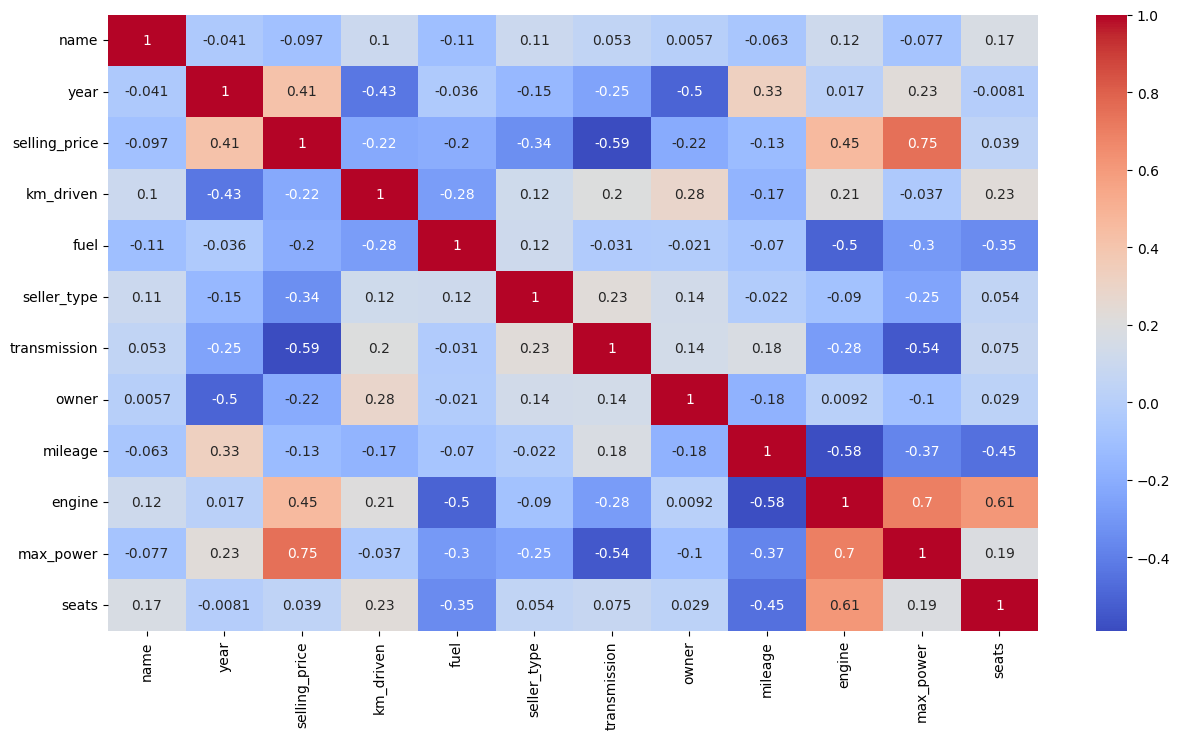

In [47]:
plt.figure(figsize = (15,8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")

**Predictive Power Socre**

We will drop the column torque

<Axes: xlabel='x', ylabel='y'>

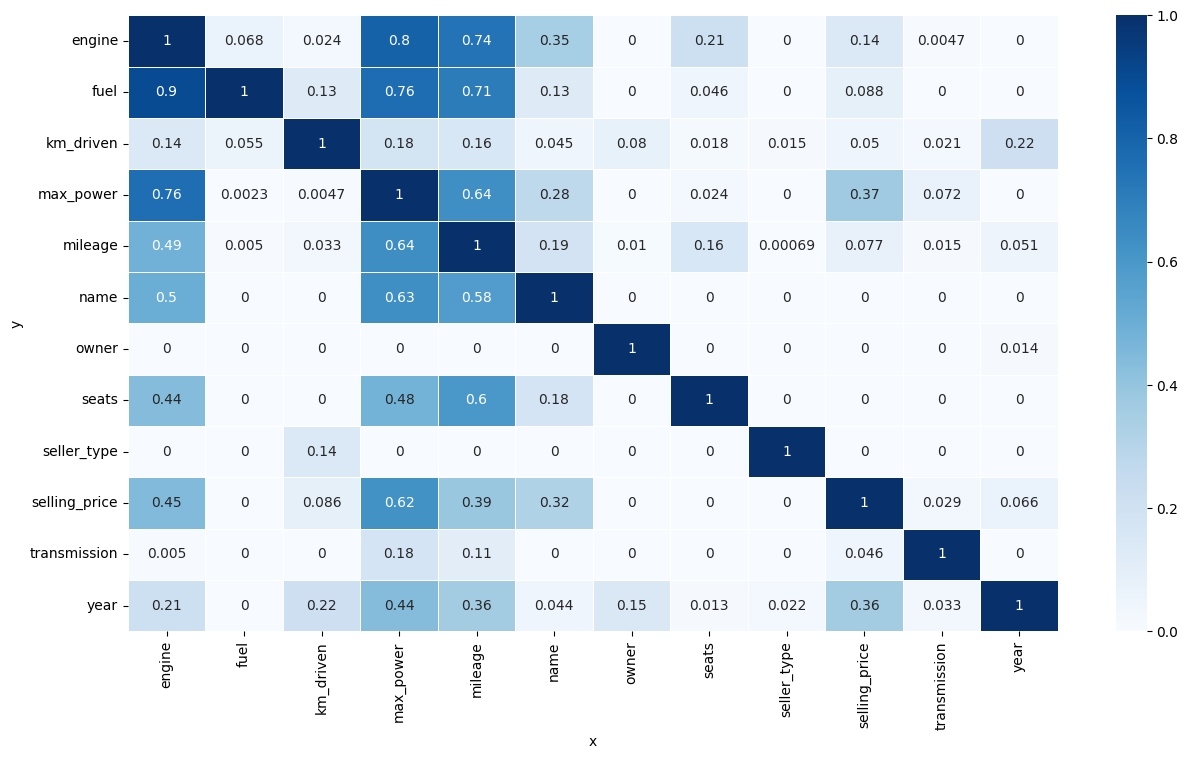

In [48]:
import ppscore as pps

dfcopy = df.copy()
dfcopy.drop(['torque'], axis='columns', inplace=True)

matrix_df = pps.matrix(dfcopy)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')

#plot
plt.figure(figsize = (15,8))
sns.heatmap(matrix_df, vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=True)

**Feature Selection**

In [49]:
# According the PPS graph, the most strong features are engine and max_power with scores 0.45 and 0.62 respectively
# Therefore, x is set to those features

X = df[['engine', 'max_power']]

# y is the selling price. As selling price values are too big, they will transformed with log
y = np.log(df['selling_price'])

**Test Train Split**

In [50]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

**Preprocessing**

Nullvalues

In [51]:
# Checking for null values

X_train[['engine', 'max_power']].isna().sum()

engine       0
max_power    0
dtype: int64

In [52]:
X_test[['engine', 'max_power']].isna().sum()

engine       0
max_power    0
dtype: int64

In [53]:
y_train.isna().sum()
y_test.isna().sum()

0

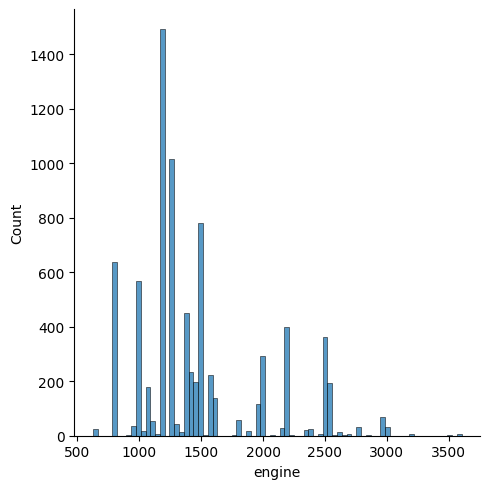

In [54]:
sns.displot(data=df, x='engine')

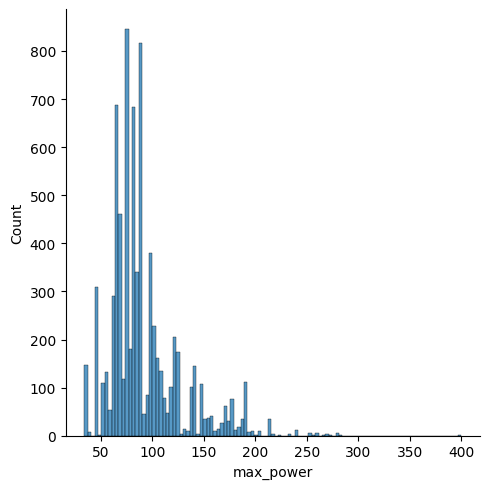

In [55]:
sns.displot(data=df, x = 'max_power')

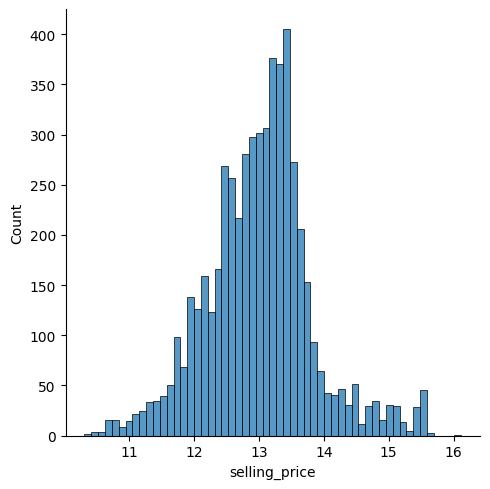

In [56]:
sns.displot(y_train)

**Checking Outliers**

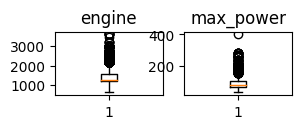

In [57]:
# Create a dictionary of columns

col_dict = {'engine': 1, 'max_power': 2}

# Box plots to detect outliers in each variables

for variable, i in col_dict.items():
  plt.subplot(5,4,i)
  plt.boxplot(X_train[variable])
  plt.title(variable)

plt.show()

In [58]:
def outlier_count(col, data = X_train):

    # calculate your 25% quatile and 75% quatile
    q75, q25 = np.percentile(data[col], [75, 25])

    # calculate your inter quatile
    iqr = q75 - q25

    # min_val and max_val
    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)

    # count number of outliers, which are the data that are less than min_val or more than max_val calculated above
    outlier_count = len(np.where((data[col] > max_val) | (data[col] < min_val))[0])

    # calculate the percentage of the outliers
    outlier_percent = round(outlier_count/len(data[col])*100, 2)

    if(outlier_count > 0):
        print("\n"+15*'-' + col + 15*'-'+"\n")
        print('Number of outliers: {}'.format(outlier_count))
        print('Percent of data that is outlier: {}%'.format(outlier_percent))

In [59]:
for col in X_train.columns:
    outlier_count(col)


---------------engine---------------

Number of outliers: 826
Percent of data that is outlier: 15.09%

---------------max_power---------------

Number of outliers: 379
Percent of data that is outlier: 6.92%


**Scaling**

In [60]:
from sklearn.preprocessing import StandardScaler

# feature scaling helps improve reach convergence faster
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

In [61]:
# Let's check shapes of all X_train, X_test, y_train, y_test
print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (5473, 2)
Shape of X_test:  (2346, 2)
Shape of y_train:  (5473,)
Shape of y_test:  (2346,)


**Modeling**

In [62]:
from sklearn.linear_model import LinearRegression  #we are using regression models
from sklearn.metrics import mean_squared_error, r2_score

lr = LinearRegression()
lr.fit(X_train, y_train)
yhat = lr.predict(X_test)

print("MSE: ", mean_squared_error(y_test, yhat))
print("r2: ", r2_score(y_test, yhat))

MSE:  0.3265346035155495
r2:  0.5390462490464738


Cross validation + Grid Search

In [63]:
from sklearn.linear_model import LinearRegression  #we are using regression models
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Libraries for model evaluation

# models that we will be using, put them in a list
algorithms = [LinearRegression(), SVR(), KNeighborsRegressor(), DecisionTreeRegressor(random_state = 0),
              RandomForestRegressor(n_estimators = 100, random_state = 0)]

# The names of the models
algorithm_names = ["Linear Regression", "SVR", "KNeighbors Regressor", "Decision-Tree Regressor", "Random-Forest Regressor"]

In [64]:
y_train.isna().sum()

0

In [65]:
from sklearn.model_selection import KFold, cross_val_score

#lists for keeping mse
train_mse = []
test_mse = []

#defining splits
kfold = KFold(n_splits=5, shuffle=True)

for i, model in enumerate(algorithms):
    scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    print(f"{algorithm_names[i]} - Score: {scores}; Mean: {scores.mean()}")

Linear Regression - Score: [-0.30890106 -0.3058399  -0.326812   -0.32905819 -0.31545157]; Mean: -0.31721254343660055
SVR - Score: [-0.26030533 -0.28544683 -0.25606483 -0.24265639 -0.26596721]; Mean: -0.26208811644745966
KNeighbors Regressor - Score: [-0.1219837  -0.12918606 -0.11481253 -0.11387203 -0.13287671]; Mean: -0.1225462074236539
Decision-Tree Regressor - Score: [-0.0991651  -0.10172482 -0.10590878 -0.09198311 -0.11523012]; Mean: -0.10280238671040912
Random-Forest Regressor - Score: [-0.10853961 -0.09061656 -0.10514549 -0.08529672 -0.09341667]; Mean: -0.09660300898933323


In [66]:
# Here we find the Random Foest Regressor has lowest score so we find the best version of the model

from sklearn.model_selection import GridSearchCV

param_grid = {'bootstrap': [True], 'max_depth': [5, 10, None],
              'n_estimators': [5, 6, 7, 8, 9, 10, 11, 12, 13, 15]}

rf = RandomForestRegressor(random_state = 1)

grid = GridSearchCV(estimator = rf,
                    param_grid = param_grid,
                    cv = kfold,
                    n_jobs = -1,
                    return_train_score=True,
                    refit=True,
                    scoring='neg_mean_squared_error')

# Fit your grid_search
grid.fit(X_train, y_train);  #fit means start looping all the possible parameters

160.91s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
160.95s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
160.95s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
160.96s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
160.97s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
160.99s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
161.00s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
161.00s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
161.00s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [67]:
grid.best_params_

{'bootstrap': True, 'max_depth': None, 'n_estimators': 15}

In [68]:
best_mse = grid.best_score_
best_mse

-0.09838403365642599

**Testing**

In [69]:
yhat = grid.predict(X_test)

y_test = np.log(y_test)
mean_squared_error(y_test, yhat)

109.55560430382123

**Inference**

In [76]:
import pickle

filename = 'model/selling-price.model'
pickle.dump(grid, open(filename, 'wb'))

In [77]:
loaded_model = pickle.load(open(filename, 'rb'))

In [78]:
df[['engine', 'max_power', 'selling_price']].loc(1)

In [79]:
predicted_selling_price = loaded_model.predict(np.array([[1500, 78]]))

In [80]:
predicted_selling_price

array([15.27389149])

In [81]:
np.exp(predicted_selling_price)

array([4298993.52800619])